In [59]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned CSVs from Drive (adjust if your path differs)
hourly = pd.read_csv("/content/drive/MyDrive/EV/data/processed/hourly_clean.csv",
                     parse_dates=["start_datetime"])
daily  = pd.read_csv("/content/drive/MyDrive/EV/data/processed/daily_clean.csv",
                     parse_dates=["start_datetime"])

# Force correct dtypes
daily["daily_kWh"]   = pd.to_numeric(daily["daily_kWh"], errors="coerce")
hourly["hourly_kWh"] = pd.to_numeric(hourly["hourly_kWh"], errors="coerce")

# Set datetime index and sort (prevents Timestamp vs int mismatches)
daily  = daily.set_index("start_datetime").sort_index()
hourly = hourly.set_index("start_datetime").sort_index()

print("Hourly dtypes:\n", hourly.dtypes)
print("\nDaily dtypes:\n", daily.dtypes)
print("\nDaily date range:", daily.index.min(), "→", daily.index.max())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Hourly dtypes:
 hourly_kWh     float64
hour             int64
day_of_week      int64
is_weekend       int64
ma_24h         float64
ma_168h        float64
dtype: object

Daily dtypes:
 daily_kWh    float64
lag_1d       float64
lag_7d       float64
lag_30d      float64
ma_7d        float64
ma_30d       float64
dtype: object

Daily date range: 1678-01-01 00:00:00 → 2262-01-01 00:00:00


In [60]:
print("Hourly shape:", hourly.shape, "| Date range:", hourly.index.min(), "→", hourly.index.max())
print("Daily shape :", daily.shape, "| Date range:", daily.index.min(), "→", daily.index.max())

print("\nDaily stats:\n", daily["daily_kWh"].describe())
print("\nHourly stats:\n", hourly["hourly_kWh"].describe())

Hourly shape: (5119225, 6) | Date range: 1678-01-01 00:00:00 → 2262-01-01 00:00:00
Daily shape : (213302, 6) | Date range: 1678-01-01 00:00:00 → 2262-01-01 00:00:00

Daily stats:
 count    213302.000000
mean          0.055789
std           1.344894
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          73.177000
Name: daily_kWh, dtype: float64

Hourly stats:
 count    5.119225e+06
mean     2.324532e-03
std      2.747515e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.317700e+01
Name: hourly_kWh, dtype: float64


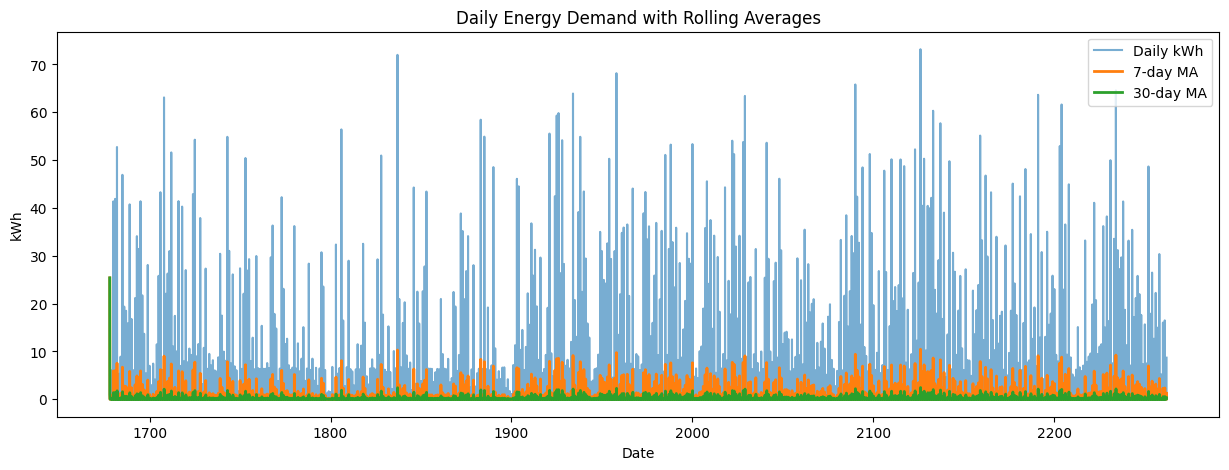

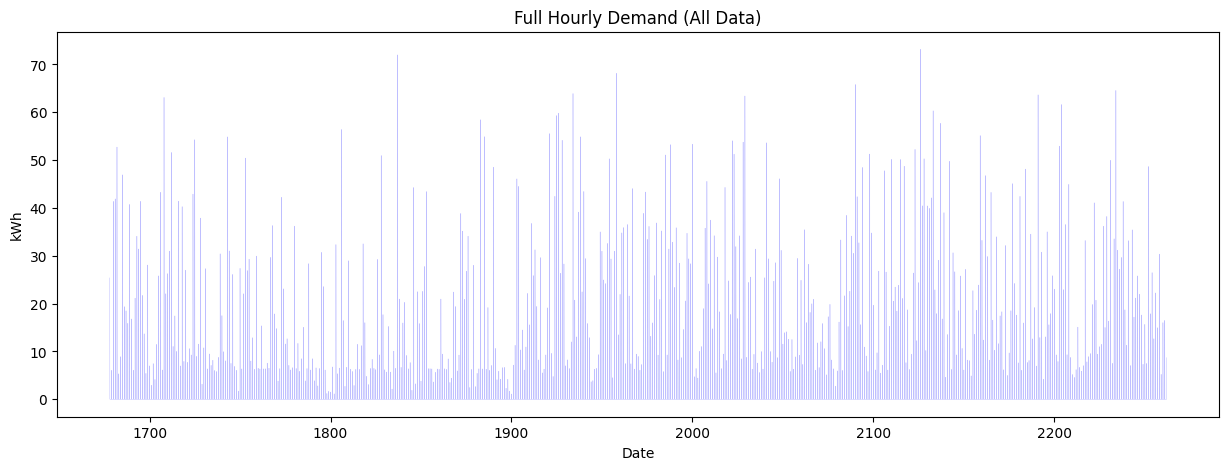

In [61]:
#Daily Demand Trend + Rolling Averages

plt.figure(figsize=(15,5))
plt.plot(daily.index, daily["daily_kWh"], label="Daily kWh", alpha=0.6)
plt.plot(daily.index, daily["ma_7d"], label="7-day MA", linewidth=2)
plt.plot(daily.index, daily["ma_30d"], label="30-day MA", linewidth=2)
plt.title("Daily Energy Demand with Rolling Averages")
plt.xlabel("Date")
plt.ylabel("kWh")
plt.legend()
plt.show()

#Hourly Demand

plt.figure(figsize=(15,5))
plt.plot(hourly.index, hourly["hourly_kWh"], color="blue", alpha=0.3, linewidth=0.3)
plt.title("Full Hourly Demand (All Data)")
plt.xlabel("Date")
plt.ylabel("kWh")
plt.show()

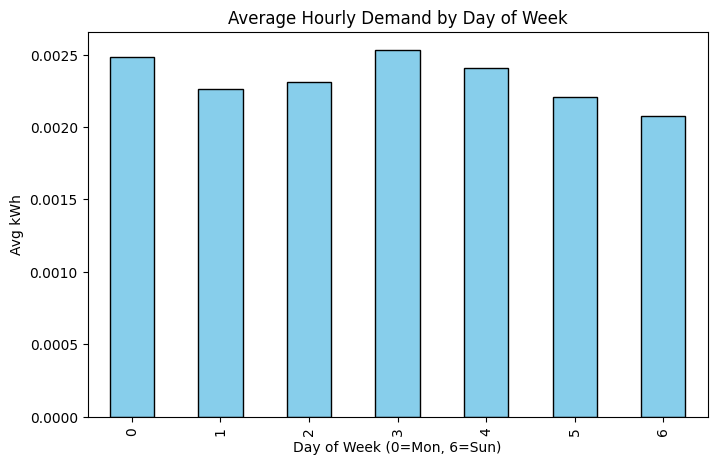

In [62]:
# --- 1) Average demand by day of week (Mon=0, Sun=6) ---
dow_avg = hourly.groupby("day_of_week")["hourly_kWh"].mean()

plt.figure(figsize=(8,5))
dow_avg.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Hourly Demand by Day of Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Avg kWh")
plt.show()

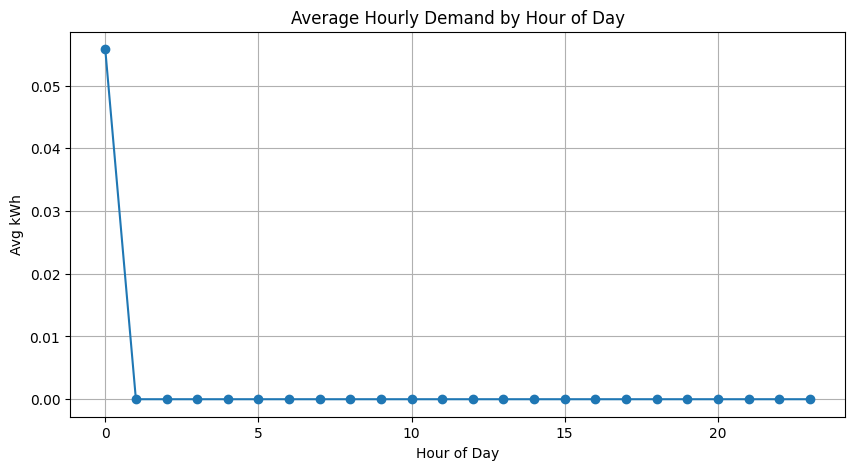

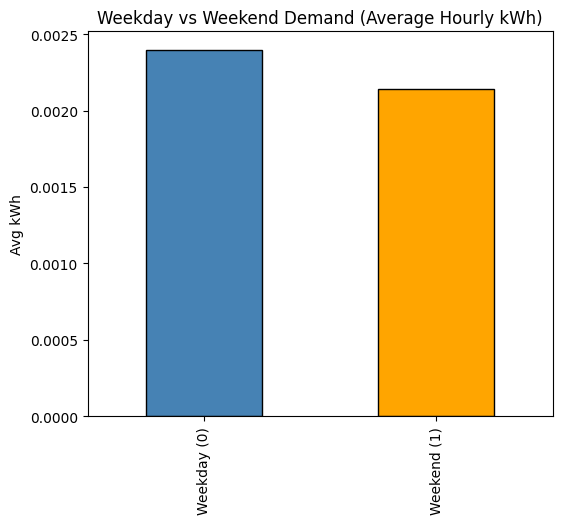

In [63]:
# --- 2) Average demand by hour of day (0–23) ---
hod_avg = hourly.groupby("hour")["hourly_kWh"].mean()

plt.figure(figsize=(10,5))
hod_avg.plot(kind="line", marker="o")
plt.title("Average Hourly Demand by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Avg kWh")
plt.grid(True)
plt.show()

#--- 3) Compare weekdays vs weekends ---
weekend_avg = hourly.groupby("is_weekend")["hourly_kWh"].mean()

plt.figure(figsize=(6,5))
weekend_avg.index = ["Weekday (0)", "Weekend (1)"]
weekend_avg.plot(kind="bar", color=["steelblue","orange"], edgecolor="black")
plt.title("Weekday vs Weekend Demand (Average Hourly kWh)")
plt.ylabel("Avg kWh")
plt.show()

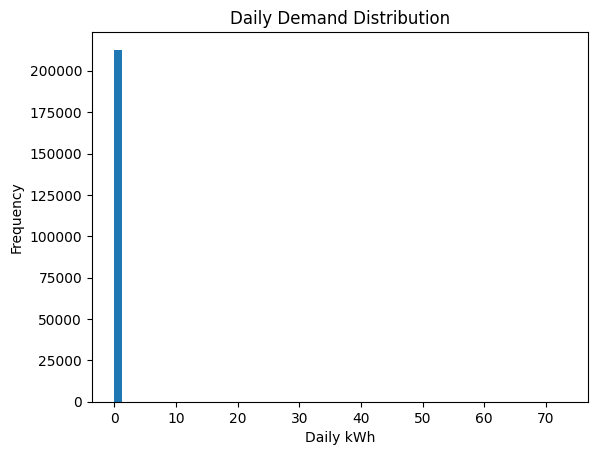

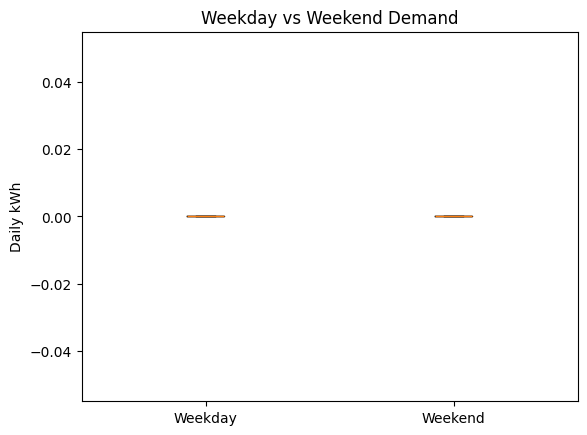

In [64]:
import matplotlib.pyplot as plt

# Histogram of daily demand
plt.hist(daily["daily_kWh"].dropna(), bins=60)
plt.title("Daily Demand Distribution")
plt.xlabel("Daily kWh"); plt.ylabel("Frequency")
plt.show()

# Boxplot: Weekday vs Weekend
daily["is_weekend"] = daily.index.dayofweek.isin([5,6])
plt.boxplot([daily.loc[~daily.is_weekend,"daily_kWh"],
             daily.loc[daily.is_weekend,"daily_kWh"]],
            labels=["Weekday","Weekend"], showfliers=False)
plt.title("Weekday vs Weekend Demand")
plt.ylabel("Daily kWh")
plt.show()

Corr(daily_kWh vs lags):
lag_1d    -0.001717
lag_7d    -0.001717
lag_30d   -0.001718
Name: daily_kWh, dtype: float64


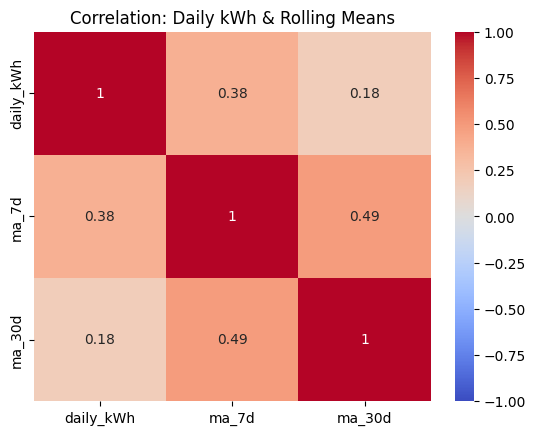

In [65]:
import seaborn as sns
# 1) Correlation of current demand with lag features
cols = [c for c in ["daily_kWh","lag_1d","lag_7d","lag_30d","ma_7d","ma_30d"] if c in daily.columns]
corr = daily[cols].corr()

print("Corr(daily_kWh vs lags):")
lags = [c for c in ["lag_1d","lag_7d","lag_30d"] if c in cols]
print(corr.loc[lags, "daily_kWh"].sort_values(ascending=False))

# 2) Heatmap: target vs rolling means
hm = daily[[c for c in ["daily_kWh","ma_7d","ma_30d"] if c in daily.columns]].corr()
sns.heatmap(hm, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation: Daily kWh & Rolling Means")
plt.show()

In [66]:
import pandas as pd

# Load again, keep datetime as a column
daily = pd.read_csv(
    "/content/drive/MyDrive/EV/data/processed/daily_clean.csv",
    parse_dates=["start_datetime"],
    index_col=None   # <-- ensures it doesn't become index
)

hourly = pd.read_csv(
    "/content/drive/MyDrive/EV/data/processed/hourly_clean.csv",
    parse_dates=["start_datetime"],
    index_col=None
)

Anomalies detected: 585 days
     start_datetime  daily_kWh
0        1678-01-01     25.370
365      1679-01-01      6.060
730      1680-01-01     41.370
1096     1681-01-01     41.890
1461     1682-01-01     52.731


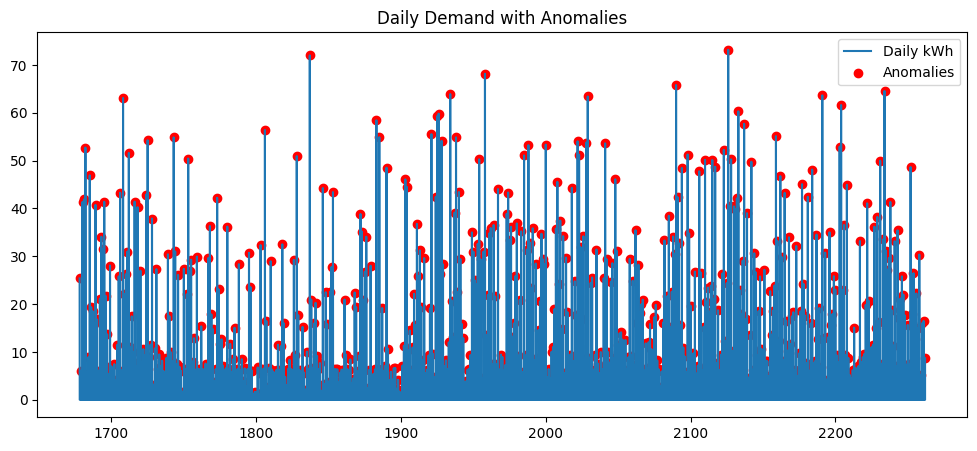

In [67]:
import matplotlib.pyplot as plt

# Define threshold using IQR (robust to skewness)
q1, q3 = daily["daily_kWh"].quantile([0.25, 0.75])
iqr = q3 - q1
low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr

# Flag anomalies
daily["is_anomaly"] = (daily["daily_kWh"] < low) | (daily["daily_kWh"] > high)
anomalies = daily[daily["is_anomaly"]]

print(f"Anomalies detected: {anomalies.shape[0]} days")
print(anomalies[["start_datetime","daily_kWh"]].head())

# Plot
plt.figure(figsize=(12,5))
plt.plot(daily["start_datetime"], daily["daily_kWh"], label="Daily kWh")
plt.scatter(anomalies["start_datetime"], anomalies["daily_kWh"], color="red", label="Anomalies")
plt.legend(); plt.title("Daily Demand with Anomalies"); plt.show()


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta


In [69]:
y = daily.set_index("start_datetime")["daily_kWh"].sort_index()

# last 90 days = test
horizon = 90
split_date = y.index.max() - timedelta(days=horizon)
y_train, y_test = y[:split_date], y[split_date+timedelta(days=1):]

print("Train:", y_train.index.min(), "→", y_train.index.max(), len(y_train))
print("Test :", y_test.index.min(),  "→", y_test.index.max(),  len(y_test))

Train: 1678-01-01 00:00:00 → 2261-10-03 00:00:00 213212
Test : 2261-10-04 00:00:00 → 2262-01-01 00:00:00 90


In [70]:
# MA(7) & MA(30) rolling
ma7   = y_train.rolling(7, min_periods=1).mean()
ma30  = y_train.rolling(30, min_periods=1).mean()

# Use last available rolling mean as constant forecast
pred_ma7  = pd.Series(ma7.iloc[-1],  index=y_test.index)
pred_ma30 = pd.Series(ma30.iloc[-1], index=y_test.index)

In [71]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA (no seasonal part)
arima_model = ARIMA(y_train, order=(1,1,1))
res_arima = arima_model.fit()

# Forecast same horizon as y_test
pred_arima = res_arima.forecast(steps=len(y_test))


In [72]:
# 1) Build y with a proper daily DateTimeIndex + freq
y = daily.set_index("start_datetime")["daily_kWh"].sort_index()

# Ensure a continuous daily index and an explicit 'D' freq
# (we filled missing days as 0 in preprocessing; keep that behavior)
y = y.asfreq("D", fill_value=0)

# 2) Split
from datetime import timedelta
horizon = 90
split_date = y.index.max() - timedelta(days=horizon)
y_train, y_test = y[:split_date], y[split_date + timedelta(days=1):]

# 3) Baselines (same as before)
ma7_last  = y_train.rolling(7,  min_periods=1).mean().iloc[-1]
ma30_last = y_train.rolling(30, min_periods=1).mean().iloc[-1]
pred_ma7  = pd.Series(ma7_last,  index=y_test.index)
pred_ma30 = pd.Series(ma30_last, index=y_test.index)

# 4) ARIMA with explicit daily freq
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(
    y_train,
    order=(1,1,1),              # non-seasonal ARIMA
    freq="D"                    # set daily frequency
)
arima_res = arima.fit()

# Forecast same horizon as y_test
pred_arima = arima_res.forecast(steps=len(y_test))

In [73]:
def mae(y, yhat):
    return np.mean(np.abs(y - yhat))

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))
def smape(y, yhat):
    return 100 * np.mean(2 * np.abs(yhat - y) / (np.abs(y) + np.abs(yhat) + 1e-6))

rows = []
for name, pred in {
    "MA(7)":   pred_ma7,
    "MA(30)":  pred_ma30,
    "ARIMA":   pred_arima,
}.items():
    rows.append({
        "Model": name,
        "RMSE":  rmse(y_test, pred),
        "MAE":   mae(y_test, pred),
        "SMAPE%": smape(y_test, pred)
    })

results = pd.DataFrame(rows).sort_values("RMSE")
print(results)

    Model      RMSE       MAE      SMAPE%
2   ARIMA  0.911621  0.155601  199.966053
0   MA(7)  0.916006  0.096556    2.222222
1  MA(30)  0.916006  0.096556    2.222222


In [74]:
# 1) Build y with a proper daily DateTimeIndex + freq
y = daily.set_index("start_datetime")["daily_kWh"].sort_index()

# Ensure a continuous daily index and an explicit 'D' freq
# (we filled missing days as 0 in preprocessing; keep that behavior)
y = y.asfreq("D", fill_value=0)

# 2) Split
from datetime import timedelta
horizon = 90
split_date = y.index.max() - timedelta(days=horizon)
y_train, y_test = y[:split_date], y[split_date + timedelta(days=1):]

# 3) Baselines
ma7_last  = y_train.rolling(7,  min_periods=1).mean().iloc[-1]
ma30_last = y_train.rolling(30, min_periods=1).mean().iloc[-1]
pred_ma7  = pd.Series(ma7_last,  index=y_test.index)
pred_ma30 = pd.Series(ma30_last, index=y_test.index)

# 4) ARIMA with explicit daily freq
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(
    y_train,
    order=(1,1,1),
    freq="D"
)
arima_res = arima.fit()

# Forecast same horizon as y_test
pred_arima = arima_res.forecast(steps=len(y_test))

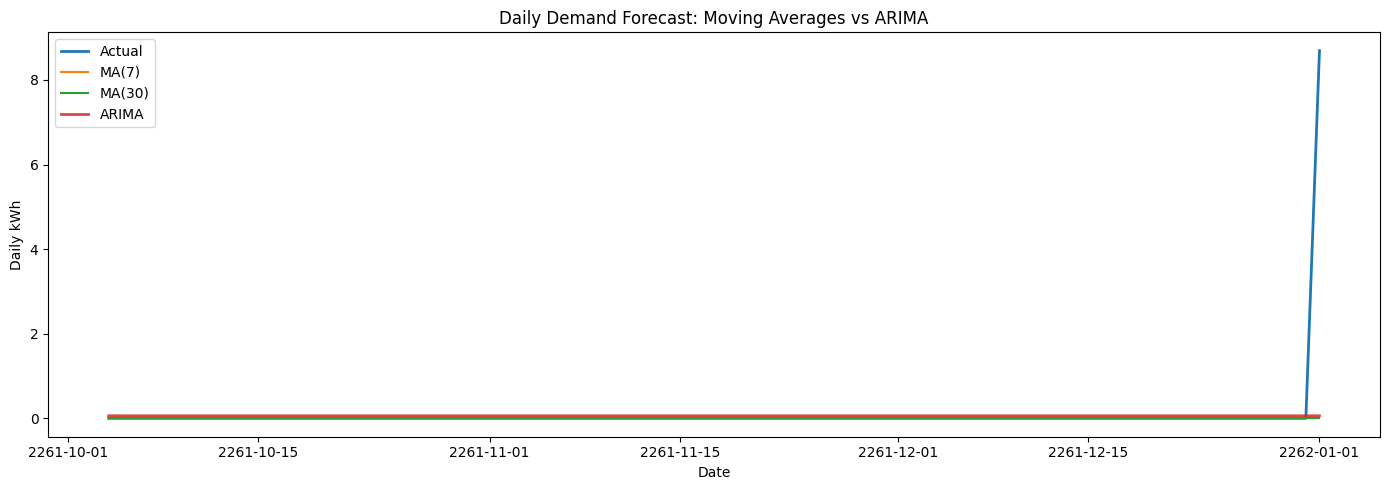

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(pred_ma7.index, pred_ma7, label="MA(7)")
plt.plot(pred_ma30.index, pred_ma30, label="MA(30)")
plt.plot(pred_arima.index, pred_arima, label="ARIMA", linewidth=2, alpha=0.85)

plt.title("Daily Demand Forecast: Moving Averages vs ARIMA")
plt.xlabel("Date")
plt.ylabel("Daily kWh")
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
# ML Forecasting (XGBoost)
import numpy as np, pandas as pd
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Series + split ----
FREQ = "D"   # set "H" for hourly later
H = 90       # forecast horizon (use 24 for hourly next-day)
y = (daily.set_index("start_datetime")["daily_kWh"]
         .sort_index().asfreq(FREQ, fill_value=0).astype(float))
offset = to_offset(FREQ)
split = y.index.max() - H*offset
y_tr, y_te = y[:split], y[split+offset:]

def metrics(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true[y_true!=0]-y_pred[y_true!=0]) / y_true[y_true!=0]))*100 if (y_true!=0).any() else np.nan
    smape = 200*np.mean(np.abs(y_pred-y_true)/(np.abs(y_true)+np.abs(y_pred)+1e-12))
    return mae, rmse, mape, smape

In [77]:
def metrics(y_true, y_pred):
    a, p = np.asarray(y_true), np.asarray(y_pred)
    mae  = np.mean(np.abs(a - p))
    rmse = np.sqrt(mean_squared_error(a, p))   # <-- fixed here
    mask = a != 0
    mape = np.mean(np.abs((a[mask] - p[mask]) / a[mask])) * 100 if mask.any() else np.nan
    smape = 200 * np.mean(np.abs(p - a) / (np.abs(a) + np.abs(p) + 1e-12))
    return mae, rmse, mape, smape


In [78]:
rows = []
for name, pred in {
    "MA(7)":  pred_ma7,
    "MA(30)": pred_ma30,
    "ARIMA":  pred_arima,
    "XGBoost": pred_xgb,
}.items():
    mae, rmse, mape, smape = metrics(y_te, pred)
    rows.append({"Model": name, "MAE": mae, "RMSE": rmse, "MAPE%": mape, "SMAPE%": smape})

results = pd.DataFrame(rows).sort_values("RMSE")
print(results)

     Model       MAE      RMSE       MAPE%      SMAPE%
2    ARIMA  0.155601  0.911621   99.305102  199.969329
0    MA(7)  0.096556  0.916006  100.000000    2.222222
1   MA(30)  0.096556  0.916006  100.000000    2.222222
3  XGBoost  0.307822  0.929664   92.696994  199.697512


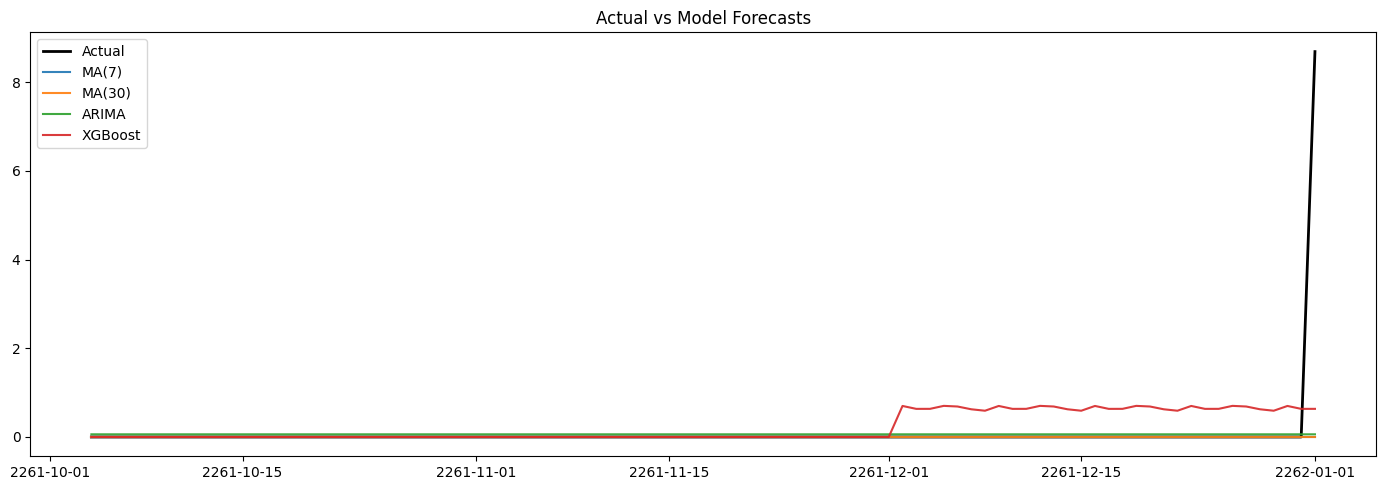

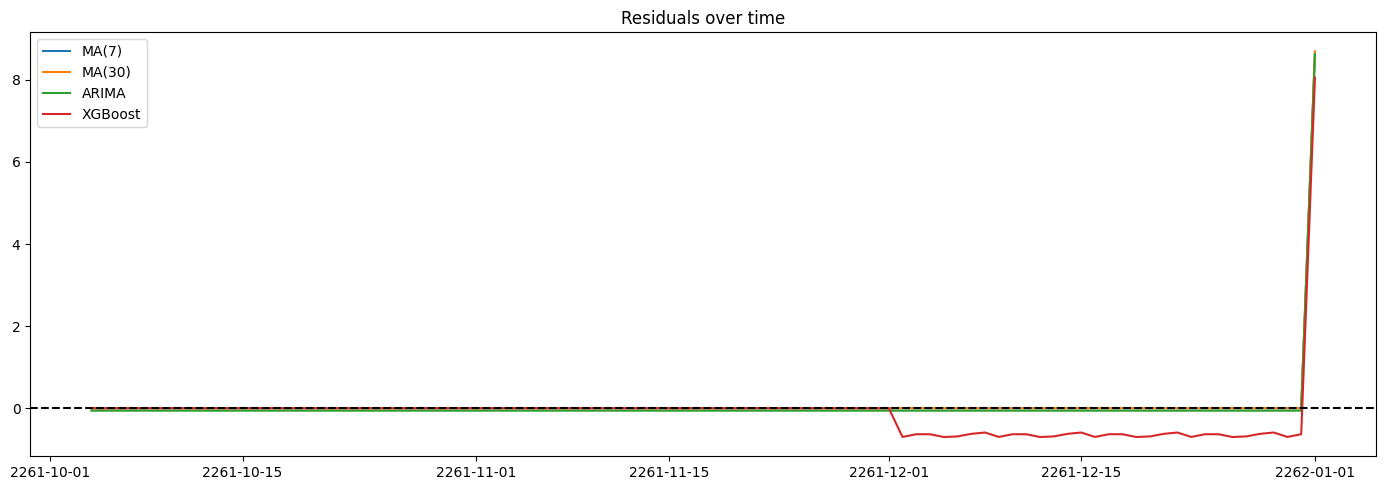

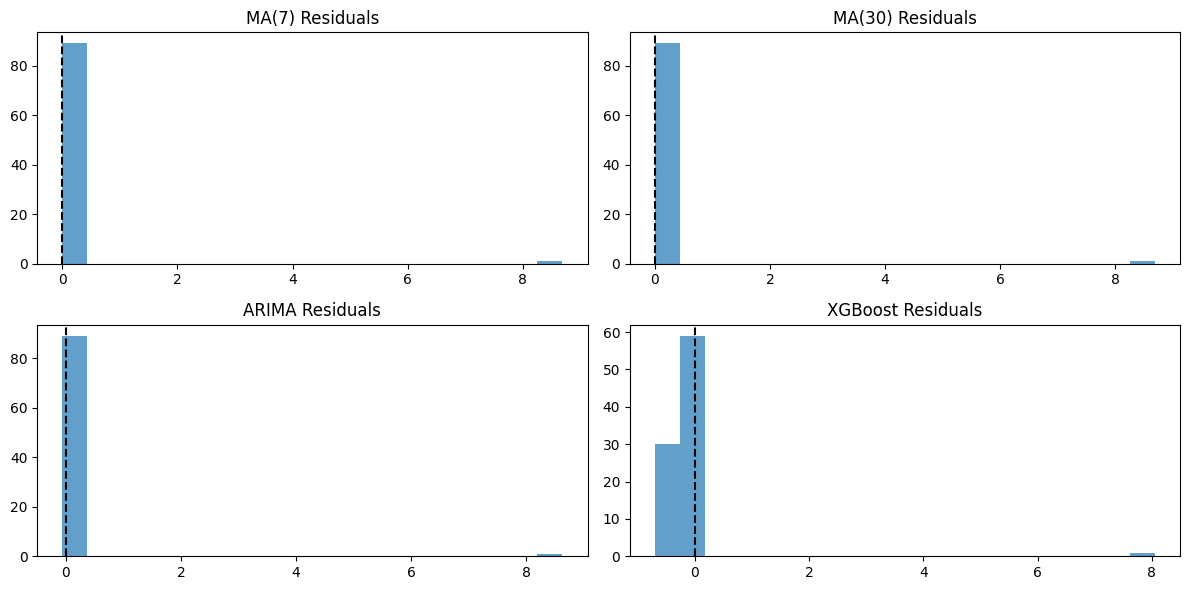

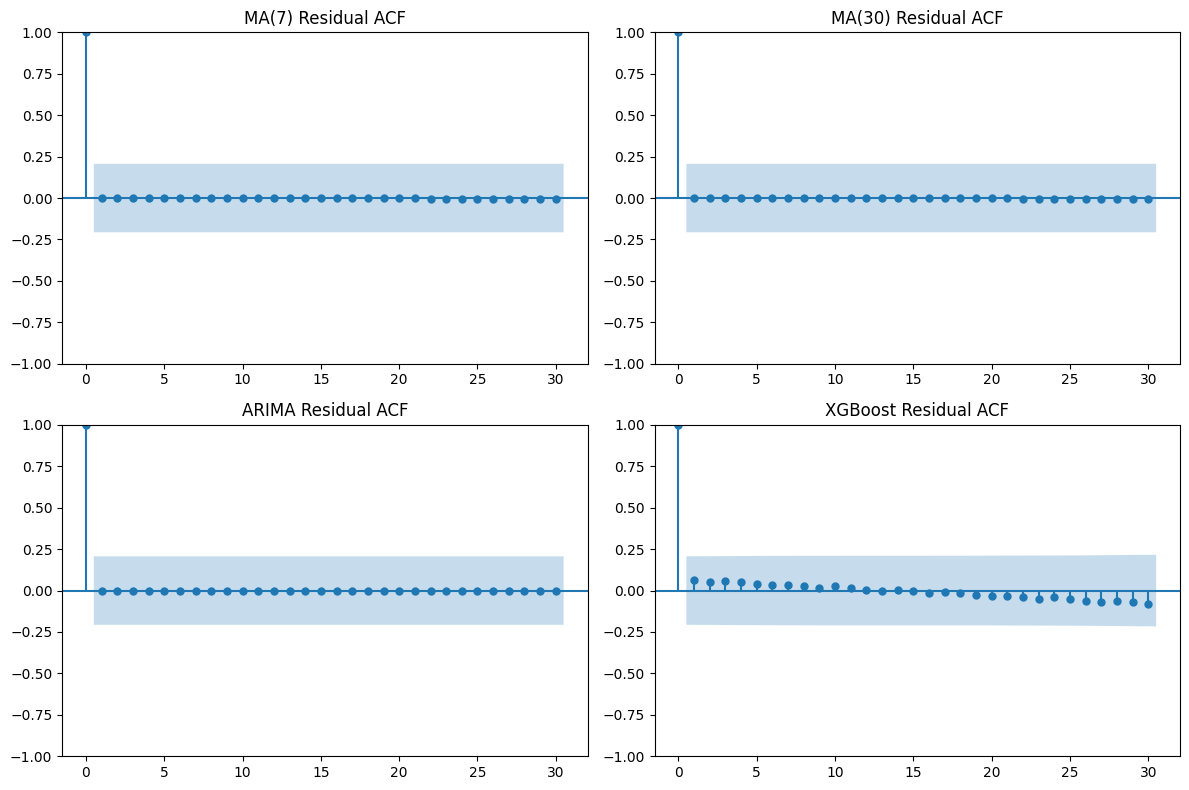

In [79]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Collect predictions in a dict (adjust if you have more models)
preds = {
    "MA(7)": pred_ma7,
    "MA(30)": pred_ma30,
    "ARIMA": pred_arima,
    "XGBoost": pred_xgb,
}

# --- 1. Actual vs Predicted (all models) ---
plt.figure(figsize=(14,5))
plt.plot(y_te.index, y_te, label="Actual", color="black", linewidth=2)
for name, pred in preds.items():
    plt.plot(pred.index, pred, label=name, alpha=0.9)
plt.title("Actual vs Model Forecasts")
plt.legend()
plt.tight_layout()
plt.show()

# --- 2. Residuals over time ---
plt.figure(figsize=(14,5))
for name, pred in preds.items():
    resid = y_te - pred
    plt.plot(resid.index, resid, label=name)
plt.axhline(0, color="black", linestyle="--")
plt.title("Residuals over time")
plt.legend()
plt.tight_layout()
plt.show()

# --- 3. Residual histogram ---
plt.figure(figsize=(12,6))
for i, (name, pred) in enumerate(preds.items(), 1):
    resid = (y_te - pred).dropna()
    plt.subplot(2,2,i)
    plt.hist(resid, bins=20, alpha=0.7)
    plt.axvline(0, color="black", linestyle="--")
    plt.title(f"{name} Residuals")
plt.tight_layout()
plt.show()

# --- 4. Residual ACF (autocorrelation) ---
fig, axes = plt.subplots(2, 2, figsize=(12,8))
for ax, (name, pred) in zip(axes.flatten(), preds.items()):
    resid = (y_te - pred).dropna()
    sm.graphics.tsa.plot_acf(resid, lags=30, ax=ax, title=f"{name} Residual ACF")
plt.tight_layout()
plt.show()
